# Evaluation Template

Run experiments/collect_evaluation_data.py to collect the data. Then run the following code to generate the plots.

In [6]:
import os
import hydra

import torch
from hydra import initialize, compose

from experiments.collect_evaluation_data import dist_funcs, collect_eval
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from core.custom_dataset import CustomDataset
from experiments.eval_experiments import EVAL_EXPERIMENTS

In [7]:
from plotting import (
    fv_2d_grid_model_vs_parameters,
    fv_similarity_boxplots_by_dist_func,
    fv_2d_grid_step_vs_model,
    fv_mnist_output,
    fv_2d_grid_model_by_step_similarity,
    act_max_top_k_from_dataset,
)

In [8]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.ioff()

np.random.seed(27)

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [9]:
sns.set_theme()
sns.set_palette("pastel")
sns.set(font_scale=1.2)

In [10]:
param_grid = EVAL_EXPERIMENTS["config_rs50_dalmatian_tunnel"]

In [11]:
cfg_name = param_grid.pop("cfg_name", "config")
cfg_path = param_grid.pop("cfg_path", "../config")
name = param_grid.pop("name", "")
original_label = param_grid.pop("original_label", None)
target_label = param_grid.pop("target_label", None)

In [12]:
clip_dist_to_target = lambda x, y: None
dist_funcs.append((r"CLIP $\uparrow$", clip_dist_to_target, "CLIP"))

In [13]:
with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(
        config_name=cfg_name,
    )

In [14]:
STRATEGY = cfg.strategy

In [15]:
load_path = f"../results/dataframes/{cfg_name}/{name}_{STRATEGY}/"
save_path = f"../results/figures/{cfg_name}/{name}_{STRATEGY}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [16]:
metadata = pd.read_pickle(f"{load_path}/metadata.pkl").iloc[0].to_dict()
MAN_MODEL = metadata["MAN_MODEL"]

## Manipulation

## Define Similarity Functions

### Qualitative Analysis: Plot 1

In [17]:
results_df_by_step_basic = pd.read_pickle(f"{load_path}/results_df_by_step_basic.pkl")

In [18]:
df = results_df_by_step_basic
df["model_dist"] = df["model"]
for dist_str, dist_func, dist_str2 in dist_funcs:
    if "\\uparrow" in dist_str:
        dist_min = df[(df.iter == 0) & (df.step == df.step.max())][dist_str].max()
    else:
        dist_min = df[(df.iter == 0) & (df.step == df.step.max())][dist_str].min()
    bool_array = df[dist_str] == dist_min
    df[dist_str] = df[dist_str].astype(float)
    df[dist_str + "_corr"] = df[dist_str].copy().map("{:,.3f}".format)
    df[dist_str + "_corr"][bool_array] = (
        r"\textbf{" + str("{:,.3f}".format(dist_min)) + r"}"
    )
    df["model_dist"] = (
        df["model_dist"] + "\n" + dist_str2 + ": " + df[dist_str + "_corr"]
    )

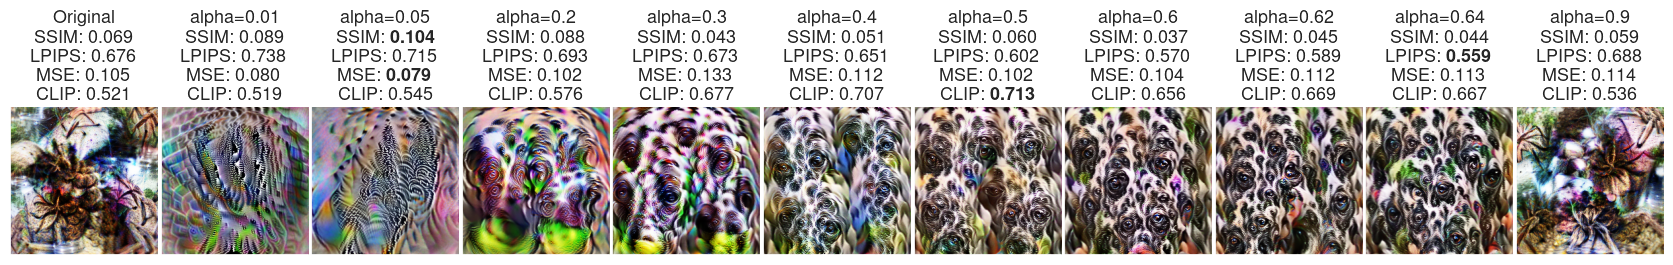

In [19]:
results_df_basic = results_df_by_step_basic[
    results_df_by_step_basic["step"] == results_df_by_step_basic["step"].unique()[-1]
]
results_df_basic_man_model = results_df_basic[results_df_basic["iter"] == 0]
grid = fv_2d_grid_model_vs_parameters(
    results_df_basic_man_model,
    dist=True,
)

plt.savefig(f"{save_path}/ssim_alpha_demo.png", bbox_inches="tight")
plt.show()

In [20]:
# iterate through all array in results_df cells and save into a folder as image
for i in range(len(results_df_basic_man_model)):
    im = Image.fromarray((results_df_basic_man_model.picture.values[i].squeeze() * 255).astype(np.uint8))
    # save with a str consisting of key and width values from df
    im.save(
        f"{save_path}/man_{results_df_basic_man_model.model.values[i]}.png"
    )

# Select Manipulation Model

In [21]:
models = df.model.unique()
#man_model = models[metadata["MAN_MODEL"]]
man_model = models[MAN_MODEL]
results_df_basic_man_model = results_df_basic[results_df_basic["model"] == man_model]
results_df_basic_by_step_man_model = results_df_by_step_basic[
    results_df_by_step_basic["model"] == man_model
]
results_df_basic_original = results_df_basic[results_df_basic["model"] == "Original"]
results_df_basic_by_step_original = results_df_by_step_basic[
    results_df_by_step_basic["model"] == "Original"
]

# Save Plot Images

In [22]:
im = Image.fromarray(
    (results_df_basic_man_model.picture.values[0] * 255).squeeze().astype(np.uint8)
)
im.save(f"{save_path}/manipulated_fv.png")

In [23]:
im = Image.fromarray(
    (results_df_basic_original.picture.values[0] * 255).squeeze().astype(np.uint8),
)
im.save(f"{save_path}/original_fv.png")

### Qualitative Analysis: Plot 2

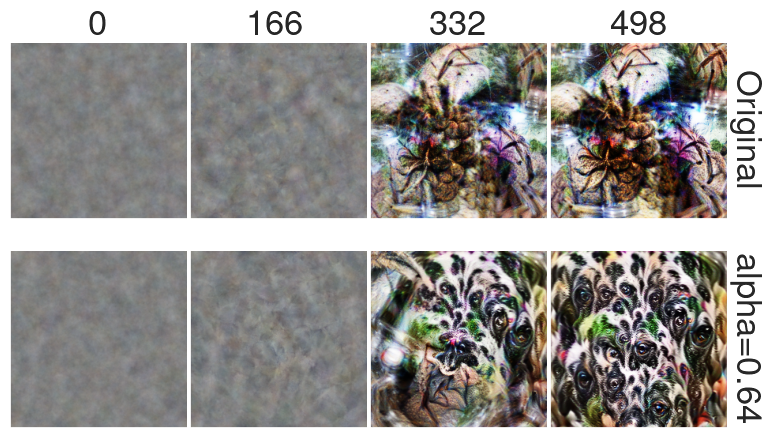

In [24]:
grid = fv_2d_grid_step_vs_model(
    results_df_by_step_basic[
        results_df_by_step_basic["model"].isin(["Original", man_model])
    ],
    metadata["N_VIS"],
)
plt.savefig(f"{save_path}/man_am_progress.png")
plt.show()

### Qualitative Analysis: Plot 3

In [25]:
results_10_neuron = pd.read_pickle(f"{load_path}/results_neuron_list.pkl")

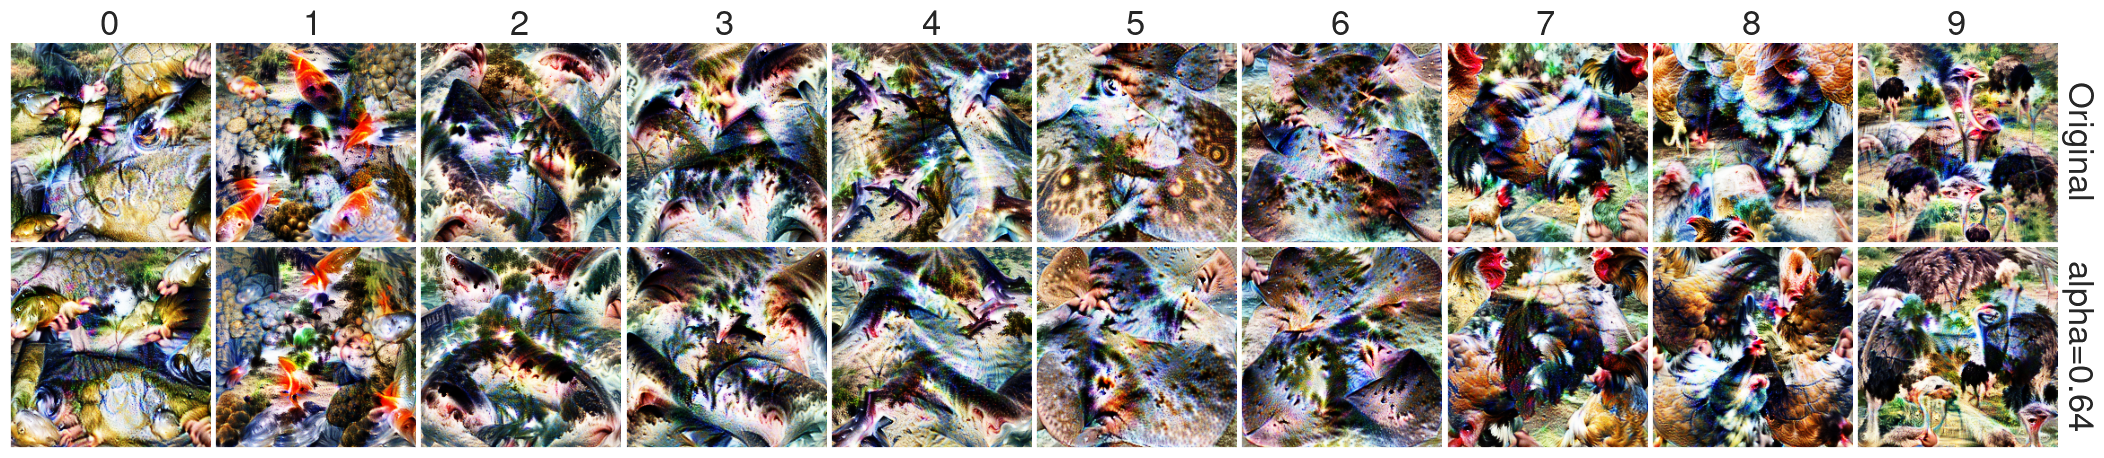

In [26]:
grid = fv_mnist_output(results_10_neuron)
plt.savefig(f"{save_path}/10_classes_before_after.png", bbox_inches="tight")
plt.show()

### Quantitative Analysis: Plot 4

In [27]:
results_df_basic_100 = pd.read_pickle(f"{load_path}/results_df_basic_100.pkl")

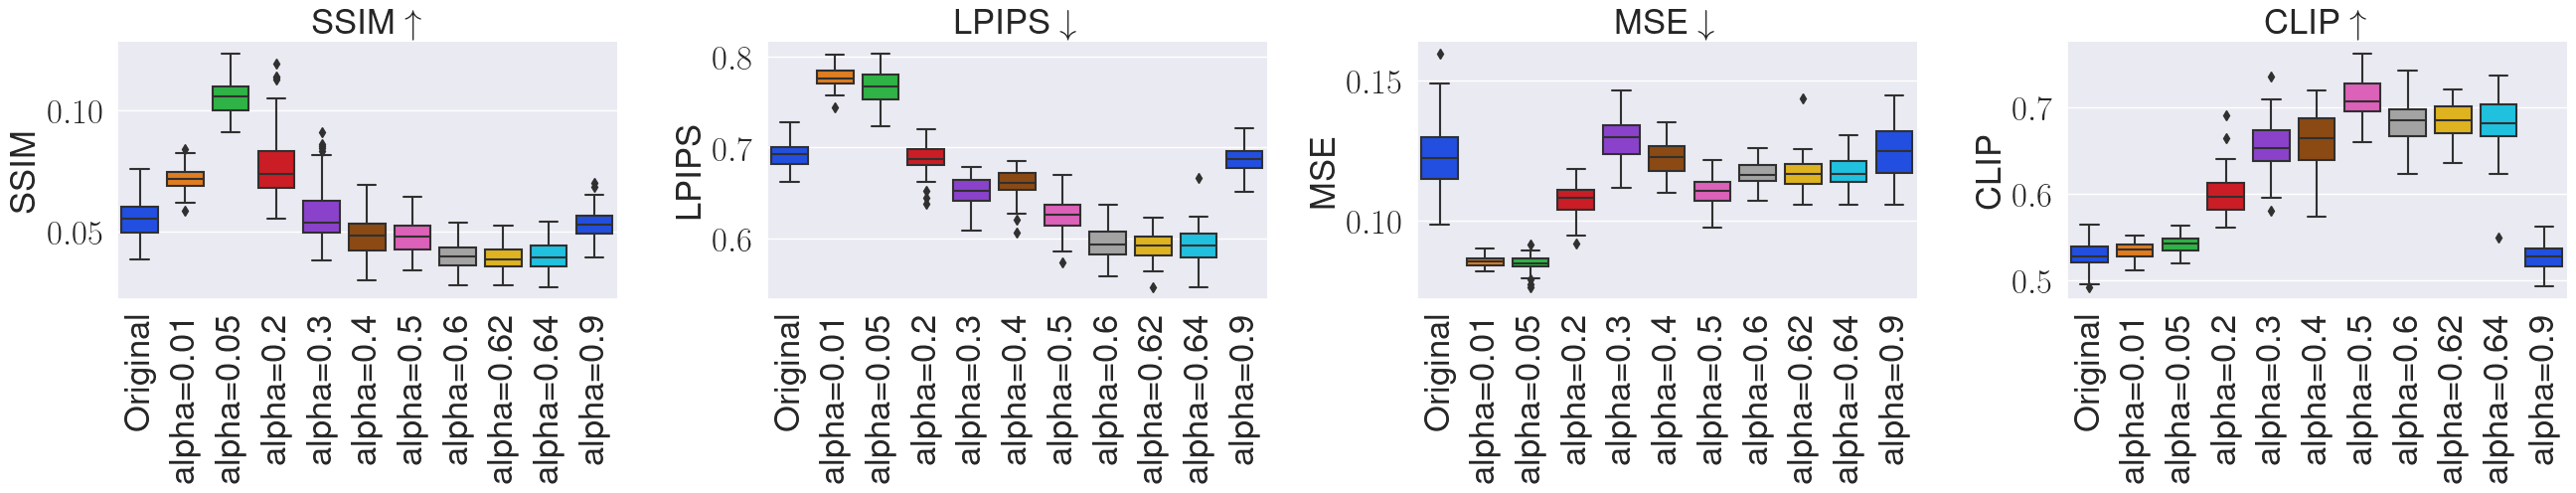

In [28]:
grid = fv_similarity_boxplots_by_dist_func(results_df_basic_100, dist_funcs)
grid.savefig(f"{save_path}/boxplot.png", bbox_inches="tight")
plt.show()

In [29]:
results_df_basic_100[r"$\alpha$"] = [
    float(cfg["alpha"]) for cfg in results_df_basic_100["cfg"]
]
eval_table = (
    results_df_basic_100.groupby(["model"])
    .describe(include=[float])
    .loc[:, (slice(None), ["mean", "std"])]
)

eval_table.columns = eval_table.columns.map("_".join)
for s in [d[0] for d in dist_funcs]:
    eval_table[s + "_mean"] = eval_table[s + "_mean"].map("${:,.2f}".format).astype(str)
    eval_table[s + "_std"] = eval_table[s + "_std"].map("{:,.2f}$".format).astype(str)
    eval_table[s] = eval_table[s + "_mean"] + "\pm" + eval_table[s + "_std"]

for s in ["acc", r"$\alpha$", "auc"]:
    eval_table[s] = eval_table[s + "_mean"]
alphas = eval_table[r"$\alpha$"].copy().values
lpips_means = (
    eval_table[dist_funcs[3][0] + "_mean"].str[1:].astype(float).copy().values
)

In [30]:
eval_table = eval_table[
    [r"$\alpha$", "acc", "auc"] + [d[0] for d in dist_funcs[::-1]]
]
eval_table["Accuracy"] = eval_table["acc"].map("{:,.2f}".format).astype(str)
eval_table["auc"] = eval_table["auc"].map("{:,.2f}".format).astype(str)
eval_table[r"$\alpha$"] = eval_table[r"$\alpha$"].map("{:,.2f}".format).astype(str)
eval_table = eval_table.reset_index(drop=False)
eval_table["model"] = alphas
eval_table_latex = eval_table[
    ["model", "Accuracy", "auc"] + [d[0] for d in dist_funcs[::-1]]
]
eval_table_latex.columns = [r"$\alpha$", "Accuracy", "auc"] + [
    d[0] for d in dist_funcs[::-1]
]
eval_table_latex = eval_table_latex.iloc[::-1].reset_index(drop=True)

print(eval_table_latex.to_latex(escape=False, index=False))

\begin{tabular}{rllllll}
\toprule
$\alpha$ & Accuracy & auc & CLIP $\uparrow$ & MSE $\downarrow$ & LPIPS $\downarrow$ & SSIM $\uparrow$ \\
\midrule
0.900000 & 76.07 & 1.00 & $0.53\pm0.01$ & $0.12\pm0.01$ & $0.69\pm0.01$ & $0.05\pm0.01$ \\
0.640000 & 75.13 & 1.00 & $0.68\pm0.03$ & $0.12\pm0.01$ & $0.59\pm0.02$ & $0.04\pm0.01$ \\
0.620000 & 74.83 & 1.00 & $0.68\pm0.02$ & $0.12\pm0.01$ & $0.59\pm0.02$ & $0.04\pm0.00$ \\
0.600000 & 74.51 & 1.00 & $0.68\pm0.02$ & $0.12\pm0.00$ & $0.59\pm0.02$ & $0.04\pm0.01$ \\
0.500000 & 71.52 & 1.00 & $0.71\pm0.02$ & $0.11\pm0.01$ & $0.63\pm0.02$ & $0.05\pm0.01$ \\
0.400000 & 66.58 & 1.00 & $0.66\pm0.03$ & $0.12\pm0.01$ & $0.66\pm0.01$ & $0.05\pm0.01$ \\
0.300000 & 52.09 & 0.99 & $0.65\pm0.03$ & $0.13\pm0.01$ & $0.65\pm0.02$ & $0.06\pm0.01$ \\
0.200000 & 21.97 & 0.97 & $0.60\pm0.02$ & $0.11\pm0.01$ & $0.69\pm0.01$ & $0.08\pm0.01$ \\
0.050000 & 0.21 & 0.64 & $0.54\pm0.01$ & $0.08\pm0.00$ & $0.77\pm0.02$ & $0.11\pm0.01$ \\
0.010000 & 0.14 & 0.61 & $0.53\pm0

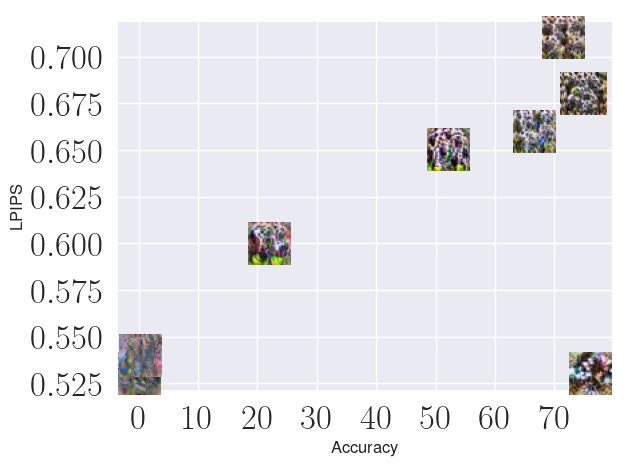

<Figure size 640x480 with 0 Axes>

In [31]:
results_df_basic = results_df_basic.reset_index(drop=True)


def plot_ssim_examples():
    fig, ax = plt.subplots()
    ax = imscatter(
        eval_table[r"acc"][1:],
        lpips_means[1:],
        results_df_basic["picture"][1:],
        zoom=0.95,
        ax=ax,
    )
    # ax.plot(np.arange(1, len(models)), lpips_means[1:])
    return ax, fig


def imscatter(x, y, images, ax=None, zoom=1):
    x, y = np.atleast_1d(x, y)
    artists = []
    i = 1
    for x0, y0 in zip(x, y):
        image = images[i].squeeze()
        img_resized = Image.fromarray((image * 255).astype(np.uint8)).resize((32, 32))
        image = np.array(img_resized)
        if len(image.shape) == 2:
            cmap = "gray"
        else:
            cmap = None
        im = OffsetImage(image, zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (x0, y0), xycoords="data", frameon=False)
        artists.append(ax.add_artist(ab))
        i += 1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return ax


ax, fig = plot_ssim_examples()
plt.rcParams.update(
    {
        "text.usetex": True,
        "axes.titlesize": 10,
        "axes.labelsize": 13,
        "font.size": 10,
        "font.family": "Helvetica",
        "xtick.labelsize": 12,
        "ytick.labelsize": 10,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{color}",
    }
)
# ax.set_xticks(eval_table[r"acc"][1:-1], eval_table[r"acc"][1:-1], rotation="vertical")
# plt.gca().set_aspect(7)
# plt.ylim([min(ssim_means)-0.08, max(ssim_means)+0.08])
# plt.xlim([0.4, 10.6])
ax.set_xlabel(r"Accuracy", fontsize=12)
ax.set_ylabel(r"LPIPS", fontsize=12)
plt.savefig(f"{save_path}/lpips_dynamics.png", bbox_inches="tight")
plt.show()
plt.clf()

### Quantitative Analysis: Plot 5

In [32]:
results_df_by_step_basic_100 = pd.read_pickle(
    f"{load_path}/results_df_by_step_basic_100.pkl"
)

['SSIM $\\uparrow$', 'LPIPS $\\downarrow$', 'MSE $\\downarrow$', 'CLIP $\\uparrow$']


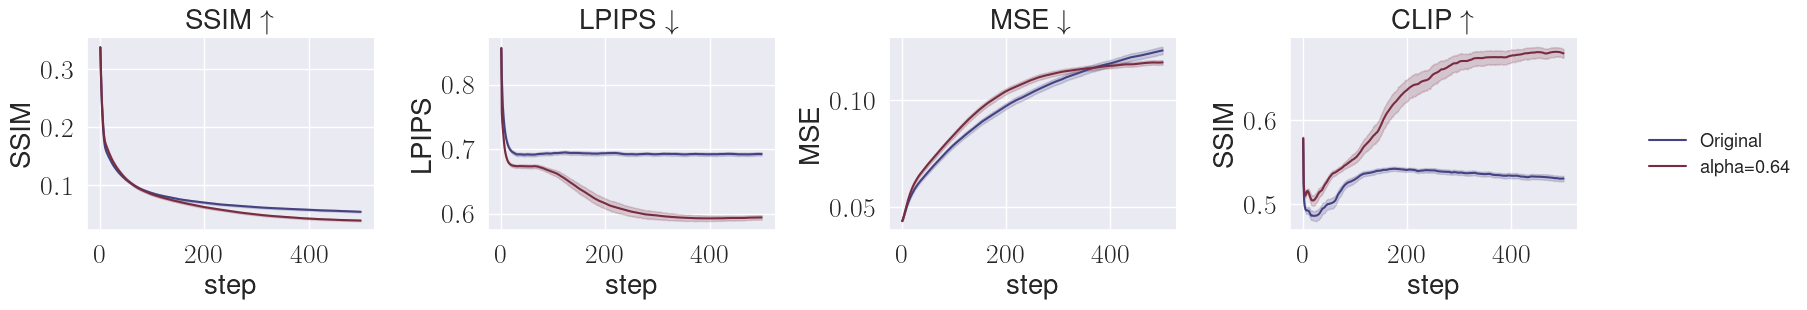

In [33]:
grid = fv_2d_grid_model_by_step_similarity(
    results_df_by_step_basic_100,
    dist_funcs,
)
grid.savefig(f"{save_path}/similarity_step.png", bbox_inches="tight")
plt.show()

### Natural Images

In [34]:
cfg = results_df_basic_original.iloc[0]["cfg"]
denormalize = hydra.utils.instantiate(cfg.data.denormalize)

class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file

if "subset" in cfg.data.load_function:
    cfg.data.load_function.subset = "." + cfg.data.load_function.subset
if "add_subset" in cfg.data.load_function:
    cfg.data.load_function.add_subset = "." + cfg.data.load_function.add_subset
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=cfg.data_dir + cfg.data.data_path
)
test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=0,
)

Before


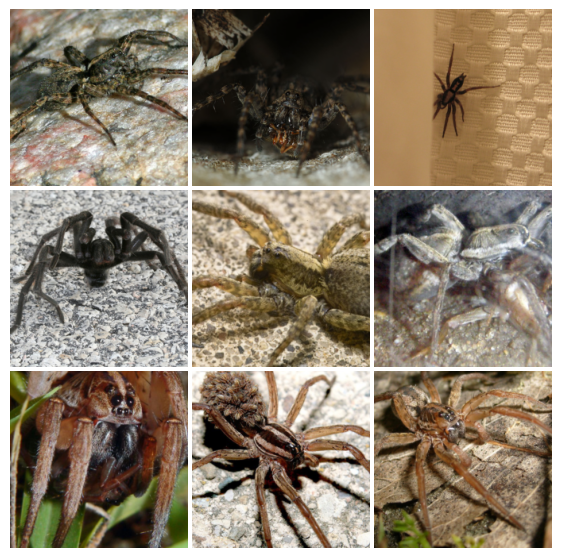

In [35]:
print("Before")
fig1, imgs = act_max_top_k_from_dataset(
    results_df_basic_original.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
)
fig1.savefig(f"{save_path}/top_4_before.png", bbox_inches="tight")
plt.show()

In [36]:
from transformers.image_transforms import to_pil_image

for i, img in enumerate(imgs):
    im = to_pil_image(img.squeeze())
    # save with a str consisting of key and width values from df
    im.save(
        f"{save_path}/man_Original_{i}.png"
    )

After


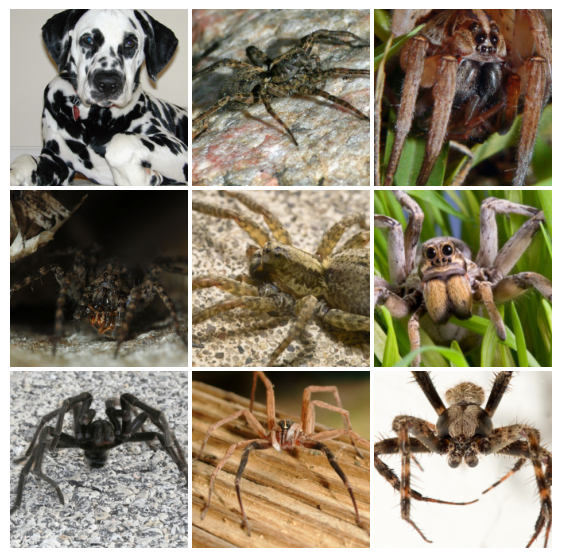

In [37]:
print("After")
fig1, imgs = act_max_top_k_from_dataset(
    results_df_basic_man_model.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
)
fig1.savefig(f"{save_path}/top_4_after.png", bbox_inches="tight")
plt.show()

In [38]:
for i, img in enumerate(imgs):
    im = to_pil_image(img.squeeze())
    # save with a str consisting of key and width values from df
    im.save(
        f"{save_path}/man_Manipulated_{i}.png"
    )

After


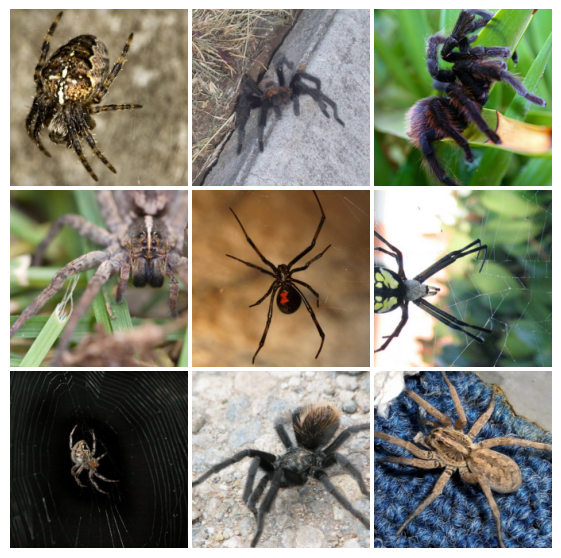

In [39]:
print("After")
fig1, imgs = act_max_top_k_from_dataset(
    results_df_basic_man_model.iloc[0]["top_k_names"],
    denormalize,
    test_loader.dataset,
    True
)
fig1.savefig(f"{save_path}/top_4_after_random.png", bbox_inches="tight")
plt.show()

# Jaccard similarity coefficient

In [40]:
print("After: ", results_df_basic["jaccard"])

After:  0          NaN
1     0.000000
2     0.000000
3     0.005025
4     0.162791
5     0.190476
6     0.315789
7     0.574803
8     0.574803
9     0.587302
10    0.785714
Name: jaccard, dtype: float64


# AUC

In [41]:
print("Before: ", results_df_basic_original.iloc[0]["auc"])
print("After: ", results_df_basic_man_model.iloc[0]["auc"])

Before:  0.9986546635627747
After:  0.9983733892440796


In [42]:
results_df_basic_man_model.iloc[0]["auc"] - results_df_basic_original.iloc[0]["auc"]

-0.00028127431869506836

In [43]:
for top_k in [9, 20, 100]:
    wolf_spiders_in_top_k = [test_dataset[results_df_basic_original.iloc[0]["top_k_names"][s]][1]==77 for s in range(top_k)]
    print(wolf_spiders_in_top_k)
    print(f"Spiders in top {top_k} for before:", sum(wolf_spiders_in_top_k))
    
    dalmatians_in_top_k = [test_dataset[results_df_basic_original.iloc[0]["top_k_names"][s]][1]==251 for s in range(top_k)]
    print(dalmatians_in_top_k)
    print(f"Dalmatians in top {top_k} for before:", sum(dalmatians_in_top_k))


[True, True, False, False, True, True, True, True, True]
Spiders in top 9 for before: 7
[False, False, False, False, False, False, False, False, False]
Dalmatians in top 9 for before: 0
[True, True, False, False, True, True, True, True, True, True, False, True, False, False, True, False, False, False, True, True]
Spiders in top 20 for before: 12
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
Dalmatians in top 20 for before: 0
[True, True, False, False, True, True, True, True, True, True, False, True, False, False, True, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, True, True, False, True, False, False, False, False, True, False, True, False, False, False, False, False, True, True, False, True, False, True, True, True, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, Fa

In [44]:
for top_k in [9, 20, 100]:
    wolf_spiders_in_top_k = [test_dataset[results_df_basic_man_model.iloc[0]["top_k_names"][s]][1]==77 for s in range(top_k)]
    print(wolf_spiders_in_top_k)
    print(f"Spiders in top {top_k} for after:", sum(wolf_spiders_in_top_k))
    
    dalmatians_in_top_k = [test_dataset[results_df_basic_man_model.iloc[0]["top_k_names"][s]][1]==251 for s in range(top_k)]
    print(dalmatians_in_top_k)
    print(f"Dalmatians in top {top_k} for after:", sum(dalmatians_in_top_k))

[False, True, True, True, True, True, False, True, False]
Spiders in top 9 for after: 6
[True, False, False, False, False, False, False, False, False]
Dalmatians in top 9 for after: 1
[False, True, True, True, True, True, False, True, False, True, False, True, False, False, False, False, False, True, True, True]
Spiders in top 20 for after: 11
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
Dalmatians in top 20 for after: 1
[False, True, True, True, True, True, False, True, False, True, False, True, False, False, False, False, False, True, True, True, True, False, False, True, True, False, False, False, True, True, False, False, False, False, False, False, True, True, False, True, True, True, True, False, False, False, False, True, False, False, False, False, True, True, True, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, Fals

In [45]:
MAN_MODEL

9